## Introduction to the Data Set
*  Import pandas, matplotlib, and numpy into the environment. Import the classes you need from scikit-learn as well.
*  Read __AmesHousing.txt__ into a pandas data frame.
*  For the following functions, we recommend creating them in the first few cells in the notebook. This way, you can add cells to the end of the notebook to do experiments and update the functions in these cells.
  *  Create a function named __transform_features()__ that, for now, just returns the __train__ data frame.
  *  Create a function named __select_features()__ that, for now, just returns the __Gr Liv Area__ and __SalePrice__ columns from the __train__ data frame.
  *  Create a function named __train_and_test()__ that, for now:
    *  Selects the first __1460__ rows from from __data__ and assign to __train__.
    *  Selects the remaining rows from __data__ and assign to __test__.
    *  Trains a model using all numerical columns except the __SalePrice__ column (the target column) from the data frame returned from __select_features()__
    *  Tests the model on the test set using and returns the RMSE value.

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('AmesHousing.txt', delimiter='\t')

In [3]:
def transform_features(df):
    return df

def select_features():
    return ['Gr Liv Area'], 'SalePrice'

def train_and_test(df, train_features, target):
    train = df.iloc[:1460].copy()
    test = df.iloc[1460:].copy()
    lr = LinearRegression()
    lr.fit(train[train_features],train[target])
    predict = lr.predict(test[train_features])
    mse = mean_squared_error(test[target],predict)
    RMSE = np.sqrt(mse)
    
    return RMSE

In [4]:
df = transform_features(data)
train_features, target = select_features()
RMSE = train_and_test(df, train_features, target)
RMSE

57088.251612639091

## Feature Engineering
1. For all columns, drop any with 5% or more missing.  This will be revisited later.
1. For the text columns, drop any with 1 or more missing values, again this will be revisited later.
1. For the numerical columns, fill NaN with the following:
  *  If the column contains continuous data fill with the mean for that column.
  *  If the column contains nominal/categorical data then fill with the mode for that column.
1. What new features be created, that better capture the information in some of the features?
1. Drop columns that aren't useful for ML
1. Drop columns that leak info about the final sale.

In [5]:
# Show all columns that have empty values
df = transform_features(data)
missing = df.isnull().sum()
print(missing[missing>0])


Lot Frontage       490
Alley             2732
Mas Vnr Type        23
Mas Vnr Area        23
Bsmt Qual           80
Bsmt Cond           80
Bsmt Exposure       83
BsmtFin Type 1      80
BsmtFin SF 1         1
BsmtFin Type 2      81
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Electrical           1
Bsmt Full Bath       2
Bsmt Half Bath       2
Fireplace Qu      1422
Garage Type        157
Garage Yr Blt      159
Garage Finish      159
Garage Cars          1
Garage Area          1
Garage Qual        159
Garage Cond        159
Pool QC           2917
Fence             2358
Misc Feature      2824
dtype: int64


In [6]:
# Make a copy of the data DF and drop all columns that have %5 or more missing values.
percent_missing = df.isnull().sum()/len(df)
drop_missing_cols = percent_missing[percent_missing > 0.05].sort_values()
df = df.drop(drop_missing_cols.index, axis=1)
print('Dropped Columns Due to > 5% missing values')
drop_missing_cols

Dropped Columns Due to > 5% missing values


Garage Type      0.053584
Garage Yr Blt    0.054266
Garage Finish    0.054266
Garage Qual      0.054266
Garage Cond      0.054266
Lot Frontage     0.167235
Fireplace Qu     0.485324
Fence            0.804778
Alley            0.932423
Misc Feature     0.963823
Pool QC          0.995563
dtype: float64

In [7]:
# Drop all text columns that have any missing values
text_cols = df.select_dtypes(include=['object'])
missing_values = text_cols.isnull().sum()
drop_missing_cols = missing_values[missing_values > 0]
df = df.drop(drop_missing_cols.index, axis=1)
print('Dropped Text Columns Due to > 1 missing value')
drop_missing_cols

Dropped Text Columns Due to > 1 missing value


Mas Vnr Type      23
Bsmt Qual         80
Bsmt Cond         80
Bsmt Exposure     83
BsmtFin Type 1    80
BsmtFin Type 2    81
Electrical         1
dtype: int64

In [8]:
# Fill continuous numerical data with mean & fill discrete numerical data with mode
num_cols = df.select_dtypes(include=['int64','float64'])
on = []
con = []

# By reviewing the data set I found that none of the ordinal/nominal data has more the 16 possibilities
for col in num_cols.columns:
    if len(num_cols[col].unique()) > 16:
        con.append(col)
    else:
        on.append(col)

print('ordinal/nominal numerical data with empty values')
missing_values = df[on].isnull().sum()
print(missing_values[missing_values > 0])

print('\ncontinuous numerical data with empty values')
missing_values = df[con].isnull().sum()
print(missing_values[missing_values > 0])

df[on] = df[on].fillna(df[on].mode().iloc[0])
df[con] = df[con].fillna(df[con].mean())

ordinal/nominal numerical data with empty values
Bsmt Full Bath    2
Bsmt Half Bath    2
Garage Cars       1
dtype: int64

continuous numerical data with empty values
Mas Vnr Area     23
BsmtFin SF 1      1
BsmtFin SF 2      1
Bsmt Unf SF       1
Total Bsmt SF     1
Garage Area       1
dtype: int64


In [9]:
# Verify that the resulting DataFrame has no missing values
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


In [10]:
# Create new features, that better captures the information.

# The 'Year Remod/Add' & 'Year Built' columns to calculate the years after the house
# was built until it was remodeled
years_until_remod = df['Year Remod/Add'] - df['Year Built']


# Similar to the above transformation... Yr Sold would provide better information if we altered it
# to the age of the house when sold.
age_when_sold = df['Yr Sold'] - df['Year Built']

# Check for negative values
print(years_until_remod[years_until_remod<0])
print(age_when_sold[age_when_sold<0])

850   -1
dtype: int64
2180   -1
dtype: int64


In [11]:
# Add newly created features and remove rows with negative values
df['years_until_remod'] = years_until_remod
df['age_when_sold'] = age_when_sold
df = df.drop([850,2180], axis=0)

## No longer need original year columns
df = df.drop(['Yr Sold', 'Year Built'], axis=1)

In [12]:
# Drop columns that aren't useful for ML
df = df.drop(['Order', 'PID'], axis=1)

# These columns have information that cannot be known 
# prior to the sale, as such they leak data.
df = df.drop(["Mo Sold", "Sale Condition", "Sale Type"], axis=1)

In [13]:
# Review data
print(df.isnull().sum())
df.info()

MS SubClass          0
MS Zoning            0
Lot Area             0
Street               0
Lot Shape            0
Land Contour         0
Utilities            0
Lot Config           0
Land Slope           0
Neighborhood         0
Condition 1          0
Condition 2          0
Bldg Type            0
House Style          0
Overall Qual         0
Overall Cond         0
Year Remod/Add       0
Roof Style           0
Roof Matl            0
Exterior 1st         0
Exterior 2nd         0
Mas Vnr Area         0
Exter Qual           0
Exter Cond           0
Foundation           0
BsmtFin SF 1         0
BsmtFin SF 2         0
Bsmt Unf SF          0
Total Bsmt SF        0
Heating              0
Heating QC           0
Central Air          0
1st Flr SF           0
2nd Flr SF           0
Low Qual Fin SF      0
Gr Liv Area          0
Bsmt Full Bath       0
Bsmt Half Bath       0
Full Bath            0
Half Bath            0
Bedroom AbvGr        0
Kitchen AbvGr        0
Kitchen Qual         0
TotRms AbvG

In [14]:
# Overwrite transform_features() so that it preforms the above feature engineering steps

def transform_features(df):
    # Drop all columns that have %5 or more missing values.
    percent_missing = df.isnull().sum()/len(df)
    drop_missing_cols = percent_missing[percent_missing > 0.05].sort_values()
    df = df.drop(drop_missing_cols.index, axis=1)
    
    # Drop all text columns that have any missing values
    text_cols = df.select_dtypes(include=['object'])
    missing_values = text_cols.isnull().sum()
    drop_missing_cols = missing_values[missing_values > 0]
    df = df.drop(drop_missing_cols.index, axis=1)
    
    # Fill missing continuous numerical data with mean & 
    # fill missing ordinal/nominal numerical data with mode
    num_cols = df.select_dtypes(include=['int64','float64'])
    on = []
    con = []
    # By reviewing the data set I found that none of the ordinal/nominal data has more the 16 possibilities
    for col in num_cols.columns:
        if len(num_cols[col].unique()) > 16:
            con.append(col)
        else:
            on.append(col)
    df[on] = df[on].fillna(df[on].mode().iloc[0])
    df[con] = df[con].fillna(df[con].mean())
    
    # Create new features, that better captures the information.
    # The 'Year Remod/Add' & 'Year Built' columns to calculate the years after the house
    # was built until it was remodeled
    df['years_until_remod'] = df['Year Remod/Add'] - df['Year Built']
    # Similar to the above transformation... Yr Sold would provide better information if we altered it
    # to the age of the house when sold.
    df['age_when_sold'] = df['Yr Sold'] - df['Year Built']
    # Remove rows with negative values
    df = df.drop([850,2180], axis=0)
    # No longer need original year columns
    df = df.drop(['Yr Sold', 'Year Built'], axis=1)
    
    # Drop columns that aren't useful for ML
    df = df.drop(['Order', 'PID'], axis=1)

    # These columns have information that cannot be known 
    # prior to the sale, as such they leak data.
    df = df.drop(["Mo Sold", "Sale Condition", "Sale Type"], axis=1)
    
    # This column really should be text as it is listed as Nominal in the data description document
    df['MS SubClass'] = df['MS SubClass'].astype('object')
    
    return df

In [15]:
# Quick Check that we get the same results as above
df = transform_features(data)
print(df.isnull().sum())
df.info()

MS SubClass          0
MS Zoning            0
Lot Area             0
Street               0
Lot Shape            0
Land Contour         0
Utilities            0
Lot Config           0
Land Slope           0
Neighborhood         0
Condition 1          0
Condition 2          0
Bldg Type            0
House Style          0
Overall Qual         0
Overall Cond         0
Year Remod/Add       0
Roof Style           0
Roof Matl            0
Exterior 1st         0
Exterior 2nd         0
Mas Vnr Area         0
Exter Qual           0
Exter Cond           0
Foundation           0
BsmtFin SF 1         0
BsmtFin SF 2         0
Bsmt Unf SF          0
Total Bsmt SF        0
Heating              0
Heating QC           0
Central Air          0
1st Flr SF           0
2nd Flr SF           0
Low Qual Fin SF      0
Gr Liv Area          0
Bsmt Full Bath       0
Bsmt Half Bath       0
Full Bath            0
Half Bath            0
Bedroom AbvGr        0
Kitchen AbvGr        0
Kitchen Qual         0
TotRms AbvG

## Feature Selection
*  Generate a correlation heatmap matrix of the numerical features in the training data set.
  *  Which features correlate strongly with our target column, __SalePrice__?
  *  Calculate the correlation coefficients for the columns that seem to correlate well with __SalePrice__. Because we have a pipeline in place, it's easy to try different features and see which features result in a better cross validation score.
*  Which columns in the data frame should be converted to the categorical data type? All of the columns marked as __nominal__ from the [documentation](DataDocumentation.txt) are candidates for being converted to categorical. Here are some other things you should think about:
  *  If a categorical column has hundreds of unique values (or categories), should you keep it? When you dummy code this column, hundreds of columns will need to be added back to the data frame.
  *  Which categorical columns have a few unique values but more than 95% of the values in the column belong to a specific category? This would be similar to a low variance numerical feature (no variability in the data for the model to capture).
*  Which columns are currently numerical but need to be encoded as categorical instead (because the numbers don't have any semantic meaning)?
*  What are some ways we can explore which categorical columns "correlate" well with __SalePrice__?
  *  Read this post for some [potential strategies](https://machinelearningmastery.com/feature-selection-machine-learning-python/).
*  Update the logic for the __select_features()__ function. This function should take in the new, modified train and test data frames that were returned from __transform_features()__.

#### Dealing with the numerical columns 1st

In [29]:
# Determine the extent that each numerical training feature coorelates to the target (SalePrice).
corrmat = df.select_dtypes(include=['int64','float64']).corr()
sorted_corrs = corrmat['SalePrice'].abs().sort_values(ascending=False)
sorted_corrs

SalePrice            1.000000
Overall Qual         0.800279
Gr Liv Area          0.712893
Garage Area          0.641433
Total Bsmt SF        0.641287
age_when_sold        0.559042
Year Remod/Add       0.533076
Mas Vnr Area         0.509181
Fireplaces           0.475073
BsmtFin SF 1         0.437376
Wood Deck SF         0.327790
Open Porch SF        0.315141
2nd Flr SF           0.269518
Lot Area             0.267122
years_until_remod    0.240133
Bsmt Unf SF          0.182944
Bedroom AbvGr        0.143939
Enclosed Porch       0.128756
Kitchen AbvGr        0.119795
Screen Porch         0.112187
Overall Cond         0.101652
Pool Area            0.068411
Low Qual Fin SF      0.037649
Bsmt Half Bath       0.035934
3Ssn Porch           0.032236
Misc Val             0.019295
BsmtFin SF 2         0.005922
Name: SalePrice, dtype: float64

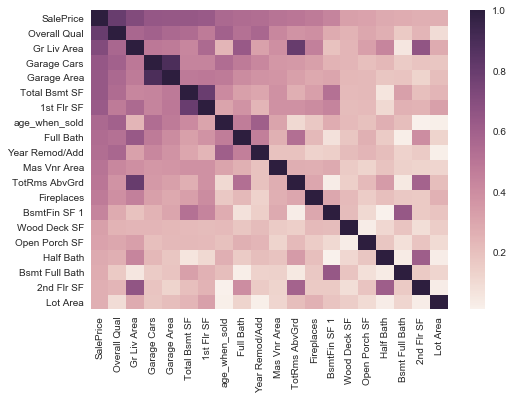

In [17]:
# Determine the extent of colinearity for each numerical training feature
# Limit the check to features with a correlation to the SalePrice >= 0.25
strong_corrs = sorted_corrs[sorted_corrs >= 0.25]
corrmat = df[strong_corrs.index].corr().abs()
fig = plt.subplots()
plt.yticks(rotation=0) 
plt.xticks(rotation=90)
sns.heatmap(corrmat)

#### Features with relatively strong colinearity
1. 1st Flr SF (Continuous) & Total Basmt SF (Continuous)
1. Gr Liv Area (Continuous) & Full Bath (Discrete)
1. Gr Liv Area (Continuous) & Half Bath (Discrete)
1. Gr Liv Area (Continuous) & TotRms AbvGrd (Discrete)
1. Garage Area (Continuous) & Garage Cars (Discrete)
1. TotRms AbvGrd (Discrete) & Full Bath (Discrete)
1. Bsmt Full Bath (Discrete) & BsmtFin SF1 (Continuous)
1. Half Bath (Discrete) & TotRms AbvGrd (Continuous)
1. 2nd Flr SF (Continuous) & Half Bath (Discrete)
1. 2nd Flr SF (Continuous) & TotRms AbvGrd (Discrete)
1. Gr Liv Area (Continuous) & 2nd Flr SF (Continuous)

#### To determine which features will be kept and which features will be dropped, the following set of criteria will be applied:
* Features that more strongly correlate with the target (SalePrice)
* Continuous data features will be favored

In [27]:
colinearity_cols = ['2nd Flr SF', '1st Flr SF', 'Total Bsmt SF', 'Gr Liv Area', 'TotRms AbvGrd', 'Full Bath',
                    'Half Bath', 'Garage Area', 'Garage Cars', 'Bsmt Full Bath', 'BsmtFin SF 1']
sorted_corrs = corrmat['SalePrice'].abs()
sorted_corrs.loc[colinearity_cols].sort_values(ascending=False)

Gr Liv Area       0.712893
Garage Cars       0.648071
Garage Area       0.641433
Total Bsmt SF     0.641287
1st Flr SF        0.632531
Full Bath         0.545641
TotRms AbvGrd     0.497966
BsmtFin SF 1      0.437376
Half Bath         0.285217
Bsmt Full Bath    0.275820
2nd Flr SF        0.269518
Name: SalePrice, dtype: float64

#### Based upon the criteria listed above the following features will be kept or dropped.
* __Featues Kept__
  1. Total Bsmt SF
  1. Gr Liv Area
  1. Garage Area
  1. BsmtFin SF 1
* __Featues Dropped__
  1. 1st Flr SF
  1. TotRms AbvGrd
  1. Full Bath
  1. Half Bath
  1. Garage Cars
  1. Bsmt Full Bath
  1. 2nd Flr SF


In [19]:
# Drop the columns due to colinearity
dropped_colinearity = ['1st Flr SF', 'TotRms AbvGrd', 'Full Bath', 
                       'Half Bath', 'Garage Cars', 'Bsmt Full Bath', '2nd Flr SF']
df = df.drop(dropped_colinearity, axis=1)

In [20]:
# Display the variance for each numerical training feature
# Of the remaining features, a variance check will be done
# Those with low variance (<0.015) will be dropped

numerical = df.select_dtypes(include=['int64','float64'])

# Rescale the numerical columns
unit = (numerical - numerical.min()) / (numerical.max() - numerical.min())

# Verify rescaling worked
print('Max Values')
print(unit.max())
print('\nMin Values')
print(unit.min())

sorted_vars = unit.var().sort_values(ascending=False)
print('\n\nSorted Variance Values')
print(sorted_vars)

print('Low Variance Features')
sorted_vars[sorted_vars<0.015]

Max Values
Lot Area             1.0
Overall Qual         1.0
Overall Cond         1.0
Year Remod/Add       1.0
Mas Vnr Area         1.0
BsmtFin SF 1         1.0
BsmtFin SF 2         1.0
Bsmt Unf SF          1.0
Total Bsmt SF        1.0
2nd Flr SF           1.0
Low Qual Fin SF      1.0
Gr Liv Area          1.0
Bsmt Half Bath       1.0
Bedroom AbvGr        1.0
Kitchen AbvGr        1.0
Fireplaces           1.0
Garage Area          1.0
Wood Deck SF         1.0
Open Porch SF        1.0
Enclosed Porch       1.0
3Ssn Porch           1.0
Screen Porch         1.0
Pool Area            1.0
Misc Val             1.0
SalePrice            1.0
years_until_remod    1.0
age_when_sold        1.0
dtype: float64

Min Values
Lot Area             0.0
Overall Qual         0.0
Overall Cond         0.0
Year Remod/Add       0.0
Mas Vnr Area         0.0
BsmtFin SF 1         0.0
BsmtFin SF 2         0.0
Bsmt Unf SF          0.0
Total Bsmt SF        0.0
2nd Flr SF           0.0
Low Qual Fin SF      0.0
Gr Liv Area 

Bsmt Half Bath     0.014962
BsmtFin SF 2       0.012293
Mas Vnr Area       0.012274
SalePrice          0.011593
Bedroom AbvGr      0.010709
Screen Porch       0.009488
Gr Liv Area        0.008919
Open Porch SF      0.008159
Wood Deck SF       0.007845
BsmtFin SF 1       0.006374
Kitchen AbvGr      0.005095
Total Bsmt SF      0.005051
Enclosed Porch     0.004019
3Ssn Porch         0.002451
Pool Area          0.001981
Low Qual Fin SF    0.001896
Lot Area           0.001351
Misc Val           0.000927
dtype: float64

#### Handling the text columns

In [21]:
# Filter for text columns and determine the number of unique values
text_cols = df.select_dtypes(include=['object'])

uv = []
for col in text_cols.columns:
    uv.append(len(text_cols[col].unique()))
    
unique_vals = pd.Series(data=uv, index=text_cols.columns).sort_values(ascending=False)
unique_vals

Neighborhood    28
Exterior 2nd    17
MS SubClass     16
Exterior 1st    16
Condition 1      9
Condition 2      8
Functional       8
Roof Matl        8
House Style      8
MS Zoning        7
Foundation       6
Roof Style       6
Heating          6
Kitchen Qual     5
Bldg Type        5
Heating QC       5
Exter Cond       5
Lot Config       5
Land Contour     4
Lot Shape        4
Exter Qual       4
Utilities        3
Land Slope       3
Paved Drive      3
Street           2
Central Air      2
dtype: int64

In [22]:
# For each nominal value do the following:
    # categorize the type
    # create dummy columns
    # append to the training df
    # remove the original column
    
for col in text_cols.columns:
    col_dummies = pd.get_dummies(df[col])
    df = pd.concat([df, col_dummies], axis=1)
    df = df.drop([col], axis=1)

df.columns

Index([      'Lot Area',   'Overall Qual',   'Overall Cond', 'Year Remod/Add',
         'Mas Vnr Area',   'BsmtFin SF 1',   'BsmtFin SF 2',    'Bsmt Unf SF',
        'Total Bsmt SF',     '2nd Flr SF',
       ...
                 'Maj2',           'Min1',           'Min2',            'Mod',
                  'Sal',            'Sev',            'Typ',              'N',
                    'P',              'Y'],
      dtype='object', length=220)

In [23]:
# Overwrite transform_features() so that it preforms the above feature engineering steps
# parameterize the following thresholds: correlation, variance, & number of unique values

def select_features(df, correlation, variance, unique_vals):
    target = 'SalePrice'
    features = []
    
    # Drop the columns due to colinearity
    dropped_colinearity = ['1st Flr SF', 'TotRms AbvGrd', 'Full Bath', 
                       'Half Bath', 'Garage Cars', 'Bsmt Full Bath', '2nd Flr SF']
     df = df.drop(dropped_colinearity.index, axis=1)
    
    # Drop each column that fails the correlation threshold
    corrmat = df.select_dtypes(include=['int64','float64']).corr()
    corrs = corrmat[target].abs()
    weak_corrs = corrs[corrs < correlation]
    df = df.drop(weak_corrs.index, axis=1)
    
    # Drop each column that fails the variance threshold
    
    
    # Drop each column that exceeds the unique_vals threshold
    
    return features, target

## 04 Train & Test
*  The optional __k__ parameter should accept integer values, with a default value of __0__.
*  When __k__ equals __0__, perform holdout validation (what we already implemented):
  *  Select the first __1460__ rows and assign to __train__.
  *  Select the remaining rows and assign to __test__.
  *  Train on train and test on __test__.
  *  Compute the RMSE and return.
*  When __k__ equals __1__, perform simple cross validation:
  *  Shuffle the ordering of the rows in the data frame.
  *  Select the first __1460__ rows and assign to __fold_one__.
  *  Select the remaining rows and assign to __fold_two__.
  *  Train on __fold_one__ and test on __fold_two__.
  *  Train on __fold_two__ and test on __fold_one__.
  *  Compute the average RMSE and return.
*  When __k__ is greater than __0__, implement k-fold cross validation using __k__ folds:
  *  Perform k-fold cross validation using __k__ folds.
  *  Calculate the average RMSE value and return this value.